In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pybaselines import Baseline
from scipy.signal import savgol_filter, find_peaks
from scipy.optimize import curve_fit
from tqdm import tqdm

In [325]:
# Load the Excel file into a DataFrame
file_path = 'intensity_data.xlsx'
df = pd.read_excel(file_path, sheet_name='data')

# Rename columns in pairs
sample_names = []
new_columns = []
for i in range(0, len(df.columns), 2):
    base_name = df.columns[i]
    sample_names.append(base_name)
    new_columns.append(f"{base_name} Raman Shift")
    new_columns.append(f"{base_name} Intensity")

# Apply the new column names to the DataFrame
df.columns = new_columns

# Drop the first row
df = df.drop(index=0).reset_index(drop=True)

# Display the updated DataFrame to check the column names
df

,CE_PIM_Pd8wt_LIG Raman Shift,CE_PIM_Pd8wt_LIG Intensity,CE_PIM_Pd4wt_LIG Raman Shift,CE_PIM_Pd4wt_LIG Intensity,CE_PIM_Pd2wt_LIG Raman Shift,CE_PIM_Pd2wt_LIG Intensity,CE_PIM_Pd1wt_LIG Raman Shift,CE_PIM_Pd1wt_LIG Intensity,CE_PIM_Zn1wt_LIG Raman Shift,CE_PIM_Zn1wt_LIG Intensity,...,CE_1per_3W_333ppi_LIG Raman Shift,CE_1per_3W_333ppi_LIG Intensity,CE_1per_3-5W_1000ppi_LIG Raman Shift,CE_1per_3-5W_1000ppi_LIG Intensity,CE_1per_3-5W_333ppi_LIG Raman Shift,CE_1per_3-5W_333ppi_LIG Intensity,2_LIG Raman Shift,2_LIG Intensity,_LIG Raman Shift,_LIG Intensity
0,3200.17,-0.110966,3200.17,-0.160609,3200.14,-0.257574,3200.14,-0.105446,3200.15,0.451541,...,3200.23,0.080267,3200.23,-0.309086,3200.23,-0.142239,3200.25,-0.431111,3200.25,-0.441426
1,3199.38,-0.104012,3199.38,-0.112895,3199.35,-0.217782,3199.35,-0.087468,3199.36,0.491584,...,3199.43,-0.474085,3199.43,-0.682637,3199.43,-0.291804,3199.46,-0.52937,3199.46,-0.353542
2,3198.59,-0.124296,3198.59,-0.088512,3198.56,-0.194627,3198.56,-0.05554,3198.56,0.532761,...,3198.64,0.215778,3198.64,-0.413167,3198.64,-0.224339,3198.67,-0.474161,3198.67,-0.490392
3,3197.8,-0.150435,3197.8,-0.139342,3197.77,-0.180511,3197.77,-0.04925,3197.77,0.521549,...,3197.85,-1.394194,3197.85,-0.358244,3197.85,-0.633941,3197.88,-0.521305,3197.88,-0.29039
4,3197,-0.138989,3197,-0.131933,3196.98,-0.196598,3196.98,-0.086657,3196.98,0.462222,...,3197.06,0.289079,3197.06,-0.249728,3197.06,-0.566441,3197.08,-0.41546,3197.08,-0.34358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,104.125,3.158338,3.028688,0.317764
3111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,102.884,3.199674,3.018483,0.315288
3112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,101.643,3.094052,3.007691,0.312837
3113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,100.402,3.119091,2.996324,0.31041


In [284]:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))


def multiple_peaks(x, *params):
    y = 0
    for i in range(0, len(params), 3):
        A, mu, sigma = map(float, params[i:i+3])  # Convert each parameter to float explicitly

        # Ensure sigma is not zero or too close to zero
        if sigma < 1e-10:
            #print("Warning: sigma is too small, adjusting to avoid division by zero.")
            sigma = 1e-10

        # Convert x to a float array, if not already
        x = np.asarray(x, dtype=float)

        # Perform the Gaussian calculation
        y += A * np.exp(-(x - mu)**2 / (2 * sigma**2))
    return y

In [359]:
# Initialise empty list to store dataframes
list_peakdf = []

# Initialise empty list to store figures
figures = []

for i in tqdm(range(0, len(df.columns), 2), desc="Processing Spectra"):
    
    sample_name = df.columns[i]

    # Convert to numeric and drop non-numeric values
    x = df.iloc[:, i].dropna()
    y = df.iloc[:, i + 1].dropna()

    y_list = y.to_list()

    # Initialize the Baseline class
    baseline_obj = Baseline()

    # Proceed with baseline correction
    try:
        baseline, params = baseline_obj.iarpls(y_list, 1e5)
        corrected_y = y - baseline
    except ValueError as e:
        print(f"Skipping pair {i//2 + 1} due to error: {e}")
        print(len(x))
        print(len(y))
        print(len(y_list))
        continue

    # Smoothing and normalization
    y_smoothed = savgol_filter(corrected_y, window_length=101, polyorder=3)
    y_sn = (y_smoothed - np.min(y_smoothed)) / (np.max(y_smoothed) - np.min(y_smoothed))

    # Peak finding
    peaks, _ = find_peaks(y_sn, prominence=0.01)
    #y_sn, height=0.05, distance=5, prominence=0.02, width=3
    
    peak_positions = x[peaks]

    # Create initial guesses for each peak
    initial_guesses = []
    for peak_position in peak_positions:
        initial_guesses.extend([np.max(y_sn[np.abs(x - peak_position) < 50]), peak_position, 10])

    # Check if initial guesses are empty
    if not initial_guesses:
        print("No peaks detected. Please adjust the prominence threshold or check your data.")
        continue  # Skip this iteration if no peaks are detected

    # Convert x to a numpy array to help with fitting
    x_array = x.to_numpy()

    lower_bounds = [0, min(x_array), 1] * (len(initial_guesses) // 3)
    upper_bounds = [np.max(y_sn), max(x_array), 100] * (len(initial_guesses) // 3)
    
    # Fit the multiple peaks
    try:
        popt, pcov = curve_fit(multiple_peaks, x_array, y_sn, initial_guesses, 
                               bounds=(lower_bounds, upper_bounds), maxfev=100000)
    except Exception as e:
        print(f"An error occurred during curve fitting: {e}")

    # Generate the fitted curve
    y_fit = multiple_peaks(x_array, *popt)
    # Fit debugging print statement
    #print("Successfully fitted")


    fig, ax = plt.subplots()
    ax.plot(x, y_sn, label='Data')
    ax.plot(x, y_fit, label='Fit')
    # Add labels for the axes
    ax.set_xlabel("Raman Shift")
    ax.set_ylabel("Intensity (a.u.)")
    
    # Add a legend to distinguish the lines
    ax.legend()
    
    figures.append(fig)  # Store the figure in the list
    plt.close(fig)  # Close the figure to prevent it from displaying

    # Extract peak information
    peak_data = []
    for i in range(len(popt) // 3):
        peak_data.append({
            "Peak Number": i + 1,
            "Center Raman Shift": popt[i*3 + 1],
            "Intensity Amplitude": popt[i*3],
            "Standard Deviation": popt[i*3 + 2]
        })

    # Create a Pandas DataFrame
    peakdf = pd.DataFrame(peak_data)

    # Calculating peak intensities
    integrated_intensities = []
    for i in range(len(popt) // 3):
        A, mu, sigma = popt[i*3 : i*3+3]  # Extract parameters for each peak
        integrated_intensity = A * sigma * np.sqrt(2 * np.pi)
        integrated_intensities.append(integrated_intensity)
    
    # Add integrated intensities to the DataFrame
    peakdf['Integrated Intensity'] = integrated_intensities

    list_peakdf.append(peakdf)

    # Clear baseline variables at the end of each iteration
    baseline = None
    params = None
    corrected_y = None
    y_smoothed = None
    y_sn = None
    peaks = None
    peak_positions = None

    pass

# Debugging print statement to ensure the list of dataframes contains all the samples
#print(len(list_peakdf))

# Creating the dictionary of dataframes
df_dict = dict(zip(sample_names, list_peakdf))
# Creating the dictionary of figures
fig_dict = dict(zip(sample_names, figures))


Processing Spectra: 100%|██████████| 39/39 [00:10<00:00,  3.65it/s]


In [353]:
# Checking the result
#print(df_dict)
Sample = 'CE_2per_4W_1000ppi_LIG'  # Replace with key
df_sample = df_dict.get(Sample)
df_sample

,Peak Number,Center Raman Shift,Intensity Amplitude,Standard Deviation,Integrated Intensity
0,1,2988.318628,0.029182,100.000000,7.314879
1,2,2702.002801,0.601620,34.447301,51.947839
2,3,2500.418687,0.022294,100.000000,5.588392
3,4,1593.275268,1.000000,30.803839,77.213773
4,5,1353.324665,0.778687,31.802486,62.074631


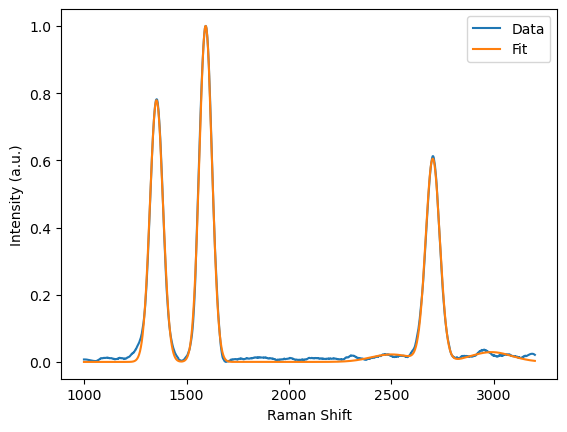

In [369]:
Sample = 'CE_2per_4W_1000ppi_LIG'  # Replace with key
spectrum_fit = fig_dict.get(Sample)
spectrum_fit